In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from src.data_loader import IMUSeq2SeqDataset
from src.Seq2Seq import Encoder, Decoder, Seq2Seq, train_loop

GLOB_PATTERN = "*.csv"
WINDOW_SIZE  = 36
STRIDE       = 6
T_IN         = 24
T_OUT        = 12
BATCH_SIZE   = 128
NUM_WORKERS  = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

windows = IMUSeq2SeqDataset.combine_csv_files(
    GLOB_PATTERN, window_size=WINDOW_SIZE, stride=STRIDE
)
print("Raw windows:", windows.shape)  # (N, T, C)

N, T, C = windows.shape
scaler = StandardScaler()
scaler.fit(windows.reshape(-1, C))  # fit across all timesteps/channels

windows_norm = scaler.transform(windows.reshape(-1, C)).reshape(N, T, C)
print("Normalized windows:", windows_norm.shape)

n_total = len(windows_norm)
n_val   = int(0.2 * n_total)
idx = np.random.permutation(n_total)
train_idx, val_idx = idx[n_val:], idx[:n_val]

train_windows = windows_norm[train_idx]
val_windows   = windows_norm[val_idx]

# -----------------------------
# Step 4: Dataset + Dataloaders
# -----------------------------
train_ds = IMUSeq2SeqDataset(train_windows, t_in=T_IN, t_out=T_OUT,
                             normalize=False, mean_removal=False)
val_ds   = IMUSeq2SeqDataset(val_windows,   t_in=T_IN, t_out=T_OUT,
                             normalize=False, mean_removal=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, drop_last=False)

encoder = Encoder(input_dim=6, d_model=128, hidden_dim=128)
decoder = Decoder(output_dim=6, hidden_dim=128, num_heads=8)
model   = Seq2Seq(encoder, decoder, teacher_forcing=0.5, pred_steps=T_OUT).to(DEVICE)

train_loop(model, train_loader, val_loader, epochs=6, lr=1e-3, device=DEVICE)

def denormalize(arr, scaler):
    """Undo normalization back to real sensor units."""
    N, T, C = arr.shape
    return scaler.inverse_transform(arr.reshape(-1, C)).reshape(N, T, C)

crit = nn.MSELoss()

def evaluate(loader):
    model.eval()
    total, n = 0.0, 0
    per_step_sqerr = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            yp, _ = model(xb)
            loss = crit(yp, yb).item()
            total += loss
            n += 1
            se = (yp - yb) ** 2
            per_t = se.mean(dim=(0,2)).detach().cpu().numpy()
            per_step_sqerr.append(per_t)
    mse = total / max(1, n)
    per_step_mse = np.mean(np.stack(per_step_sqerr, axis=0), axis=0)
    return mse, np.sqrt(mse), np.sqrt(per_step_mse)

val_mse, val_rmse, per_step_rmse = evaluate(val_loader)
print(f"[MODEL]  Val MSE: {val_mse:.6f} | Val RMSE: {val_rmse:.6f}")
print("Per-horizon RMSE:", np.round(per_step_rmse, 4))

def repeat_last_baseline(loader):
    total, n = 0.0, 0
    per_step_sqerr = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            last = xb[:, -1:, :]
            yp   = last.repeat(1, yb.size(1), 1)
            loss = F.mse_loss(yp, yb).item()
            total += loss
            n += 1
            se = (yp - yb) ** 2
            per_t = se.mean(dim=(0,2)).detach().cpu().numpy()
            per_step_sqerr.append(per_t)
    mse = total / max(1, n)
    per_step_mse = np.mean(np.stack(per_step_sqerr, axis=0), axis=0)
    return mse, np.sqrt(mse), np.sqrt(per_step_mse)

bl_mse, bl_rmse, bl_per_step_rmse = repeat_last_baseline(val_loader)
print(f"[BASE]   Val MSE: {bl_mse:.6f} | Val RMSE: {bl_rmse:.6f}")
print("Per-horizon RMSE (baseline):", np.round(bl_per_step_rmse, 4))

impr = (bl_mse - val_mse) / max(1e-9, bl_mse) * 100.0
print(f"Relative improvement vs baseline: {impr:.2f}%")

X_in, Y_out = next(iter(val_loader))
X_in, Y_out = X_in.to(DEVICE), Y_out.to(DEVICE)
with torch.no_grad():
    preds, _ = model(X_in)

preds_denorm = denormalize(preds.cpu().numpy(), scaler)
y_true_denorm = denormalize(Y_out.cpu().numpy(), scaler)

i, ch = 0, 0
t = np.arange(T_OUT)
plt.figure()
plt.plot(t, y_true_denorm[i,:,ch], label="true")
plt.plot(t, preds_denorm[i,:,ch], label="pred")
plt.legend(); plt.xlabel("horizon step"); plt.ylabel(f"channel {ch}")
plt.title("Pred vs True (denormalized, one sample)")
plt.show()


Using device: cpu
Final dataset shape (windows): (16783, 36, 6)
Raw windows: (16783, 36, 6)
Normalized windows: (16783, 36, 6)
Epoch 01 | train MSE 0.275144 | val MSE 0.148297
Epoch 02 | train MSE 0.138656 | val MSE 0.135299
Epoch 03 | train MSE 0.130491 | val MSE 0.134317


In [9]:
import torch
import numpy as np
import pandas as pd
import joblib
from torch.utils.data import DataLoader
from src.data_loader import IMUSeq2SeqDataset
from src.Seq2Seq import Encoder, Decoder, Seq2Seq
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


T_IN   = 24
T_OUT  = 12
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = joblib.load("scaler.pkl")

encoder = Encoder(input_dim=6, d_model=128, hidden_dim=128)
decoder = Decoder(output_dim=6, hidden_dim=128, num_heads=8)
model   = Seq2Seq(encoder, decoder, teacher_forcing=0.0, pred_steps=T_OUT).to(DEVICE)  # disable teacher forcing at inference
model.load_state_dict(torch.load("seq2seq_model.pt", map_location=DEVICE))
model.eval()

print("Model and scaler loaded.")

def load_and_preprocess_csv(file_path, window_size=36, stride=6):
    df = pd.read_csv(file_path)
    data = df[["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]].values

    windows = []
    for start in range(0, len(data) - window_size + 1, stride):
        window = data[start:start+window_size]
        windows.append(window)

    if len(windows) == 0:
        raise ValueError("Not enough data to form one window.")

    windows = np.stack(windows)
    # Apply same global scaler
    N, T, C = windows.shape
    windows_norm = scaler.transform(windows.reshape(-1, C)).reshape(N, T, C)
    return windows_norm

def predict_on_file(file_path):
    windows_norm = load_and_preprocess_csv(file_path)

    dataset = IMUSeq2SeqDataset(windows_norm, t_in=T_IN, t_out=T_OUT,
                                normalize=False, mean_removal=False)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    preds_all = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            pred, _ = model(xb)  # (1, T_OUT, C)
            pred = pred.cpu().numpy()
            preds_all.append(pred)

    preds_all = np.concatenate(preds_all, axis=0)  # (N, T_OUT, C)

    # Denormalize back to real values
    N, T, C = preds_all.shape
    preds_denorm = scaler.inverse_transform(preds_all.reshape(-1, C)).reshape(N, T, C)

    return preds_denorm



Model and scaler loaded.


C:\Users\ammou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluation on snaptic_log_20250918_143640.csv
MSE:  34453.6836
RMSE: 185.6170
R²:   0.8267


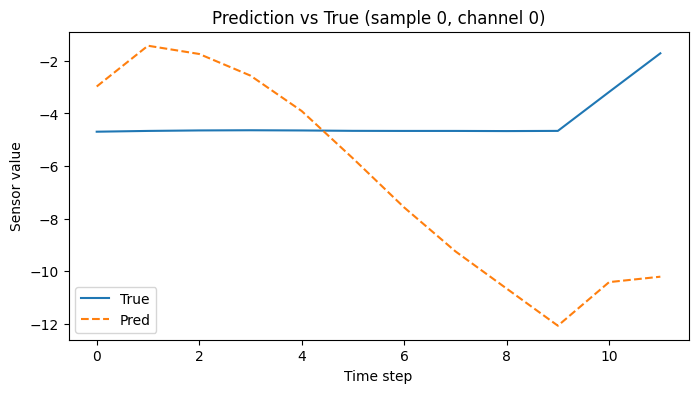

In [10]:
def predict_and_evaluate(file_path):

    windows_norm = load_and_preprocess_csv(file_path)

    dataset = IMUSeq2SeqDataset(
        windows_norm, t_in=T_IN, t_out=T_OUT,
        normalize=False, mean_removal=False
    )
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    preds_all, trues_all = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred, _ = model(xb)  # (1, T_OUT, C)

            preds_all.append(pred.cpu().numpy())
            trues_all.append(yb.cpu().numpy())

    preds_all = np.concatenate(preds_all, axis=0)  # (N, T_OUT, C)
    trues_all = np.concatenate(trues_all, axis=0)  # (N, T_OUT, C)

    N, T, C = preds_all.shape
    preds_denorm = scaler.inverse_transform(preds_all.reshape(-1, C)).reshape(N, T, C)
    trues_denorm = scaler.inverse_transform(trues_all.reshape(-1, C)).reshape(N, T, C)

    mse = mean_squared_error(trues_denorm.reshape(-1, C), preds_denorm.reshape(-1, C))
    rmse = np.sqrt(mse)
    r2 = r2_score(trues_denorm.reshape(-1, C), preds_denorm.reshape(-1, C))

    print(f"Evaluation on {file_path}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    i, ch = 0, 0
    plt.figure(figsize=(8,4))
    plt.plot(trues_denorm[i,:,ch], label="True")
    plt.plot(preds_denorm[i,:,ch], label="Pred", linestyle="--")
    plt.title(f"Prediction vs True (sample {i}, channel {ch})")
    plt.xlabel("Time step")
    plt.ylabel("Sensor value")
    plt.legend()
    plt.show()

    return preds_denorm, trues_denorm

if __name__ == "__main__":
    file_path = "snaptic_log_20250918_143640.csv"
    preds, trues = predict_and_evaluate(file_path)